# Bitcoin Momentum Trading Strategy
    The following notebook aims to classify trading signal (buy or sell) for Bitcoin using historical data from 01/01/2012 to 31/12/2020. 
    We will employ and compare prediction performance of various Machine Learning algorithms.

## 1. Import data and packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import klib
import ta
import scipy.stats as st

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# Suppress warning
pd.options.mode.chained_assignment = None  # default='warn'


Data can be downloaded from Kaggle website with further description in Readme.txt

In [2]:
# Load data
data = pd.read_csv('bitcoin.csv')

## 2. Features Engineering
    Since we will create new features, data exploratory analysis will be performed later to have a full picture.

### 2.1 Original data 

Since data is collected every 1 minute from 2012 to end of 2020, we have nearly 5 million data points with 8 features in Unix timestamps.

In [ ]:
# Shape of data
data.shape

(4727777, 8)

In [ ]:
# Take a peek
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Statistics
data.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.727777e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06
mean,1.467409e+09,4.570658e+03,4.573721e+03,4.567413e+03,4.570624e+03,9.422676e+00,3.315691e+04,4.570625e+03
std,8.203749e+07,4.775105e+03,4.778620e+03,4.771352e+03,4.775094e+03,3.101255e+01,1.129107e+05,4.775090e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.396235e+09,4.321900e+02,4.324300e+02,4.320000e+02,4.322000e+02,3.917811e-01,4.147936e+02,4.321753e+02
50%,1.467540e+09,3.085010e+03,3.093250e+03,3.078010e+03,3.084410e+03,1.936719e+00,3.305199e+03,3.085478e+03
75%,1.538456e+09,8.158010e+03,8.162850e+03,8.152790e+03,8.157310e+03,7.299825e+00,2.158297e+04,8.157964e+03
max,1.609373e+09,2.899738e+04,2.901032e+04,2.896366e+04,2.899738e+04,5.853852e+03,1.044599e+07,2.898589e+04


Nearly 27% of data points is NaNs, which will be forward filled. 

In [ ]:
# Check % of NaN values
data.isnull().mean()

Timestamp            0.000000
Open                 0.263014
High                 0.263014
Low                  0.263014
Close                0.263014
Volume_(BTC)         0.263014
Volume_(Currency)    0.263014
Weighted_Price       0.263014
dtype: float64

### 2.2 Creating labels and preprocessing data

NaN values will be imputed using last data point values.   
Furthermore, timestamp column will be dropped.

In [3]:
# Perform forward fill on NaNs
data_filled = data.ffill(axis=0)

In [ ]:
# Recheck NaN values
data_filled.isnull().mean()

Timestamp            0.0
Open                 0.0
High                 0.0
Low                  0.0
Close                0.0
Volume_(BTC)         0.0
Volume_(Currency)    0.0
Weighted_Price       0.0
dtype: float64

Convert unix timestamp to datetime and set as index.

In [4]:
# Convert unix time to date time
data_filled['Timestamp'] = pd.to_datetime(data_filled['Timestamp'],unit='s')

In [5]:
# Set Timestamp as index
data_filled.set_index('Timestamp')


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
...,...,...,...,...,...,...,...
2020-12-30 23:56:00,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
2020-12-30 23:57:00,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
2020-12-30 23:58:00,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266


Downsample data in minutes to hourly data. Overall we will have a dataset of around 80,000 data points

In [6]:
# Convert to every 60 min data
hourly_data = data_filled.resample('60min', on='Timestamp').agg({'Open':'first', 'High':'max', 'Low':'min','Close':'last', 'Volume_(BTC)':'sum', 'Volume_(Currency)':'sum','Weighted_Price':'mean'})

In [7]:
# Check for null value
hourly_data.isnull().sum()

Open                 107
High                 107
Low                  107
Close                107
Volume_(BTC)           0
Volume_(Currency)      0
Weighted_Price       107
dtype: int64

In [8]:
# Forward fill NaN:
df = hourly_data.ffill(axis=0)

In [ ]:
# Save df
df.to_csv('bitcoin_hour.csv')

In [ ]:
df = pd.read_csv('bitcoin_hour.csv')

In [9]:
# Inspect data shape
df.shape

(78906, 7)

The purpose of this model is to identify trading strategy, whether to sell or buy Bitcoin by looking at signal.  

Moving average (MA) will be chosen as it is one of the most common technical indicators. MA support identify support and resistance level as well as overall trends.  

Common long-term MA period is 50, 100 and 200-day while short term period includes 5, 10, 20, 50-day.  

Moreover, position columns (long/short position) will also be added by calculating the difference of signal. 
Now, we will create target label (signal) for the dataset.   
- High(1): when short-term (10 days) price will be higher than long-term (50 days) price.
- Low(0): when short-term price will be lower than long-term price. 

Since our data is hourly data, we will choose rolling window of 10 days by multiple by 24 hour for each day

In [10]:
# Create moving average of window size 10*24
df['ma_short'] = df['Close'].rolling( window = 10*24, min_periods=1).mean()

# Create moving average of window size 50
df['ma_long'] = df['Close'].rolling(window = 50*24, min_periods=1).mean()

# Initialize signal colum
df['signal'] = 0.0

# Assign signal from data point 10th since we don't have historical data for the first 10 day:
df['signal'][240:] = np.where(df['ma_short'][240:] > df['ma_long'][240:],1.0,0.0)

# Create trading position column
df['positions'] = df['signal'].diff()

In [ ]:
# Inspect new df
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ma_short,ma_long,signal,positions
Timestamp,,,,,,,,,,,
2012-01-01 00:00:00,4.58,4.58,4.58,4.58,540.000,2473.20000,4.58,4.58,4.58,0.0,NaN
2012-01-01 01:00:00,4.58,4.58,4.58,4.58,540.000,2473.20000,4.58,4.58,4.58,0.0,0.0
2012-01-01 02:00:00,4.58,4.58,4.58,4.58,540.000,2473.20000,4.58,4.58,4.58,0.0,0.0
2012-01-01 03:00:00,4.58,4.58,4.58,4.58,540.000,2473.20000,4.58,4.58,4.58,0.0,0.0
2012-01-01 04:00:00,4.58,4.58,4.58,4.58,210.088,962.20304,4.58,4.58,4.58,0.0,0.0


### 2.3 Create Trading Indicators

New features will be added by using current variables to calculate trading indicators. We will create indicators as below:  
- Trend: Exponential Moving Average (EMA), Average Directional Movement Index (ADX).   
- Momentum: Stochastic Oscillator (SR), Rate of Change (ROC), Relative Strength Index (RSI).  
- Volatility: Average True Range (ATR), Bollinger Bands (BB)  .


- Exponential Moving Average (EMA) : a variant of moving average (MA) that places a greater weight and significance on the most recent data points

In [11]:

# Create 1 and 10 day EMA object 
ema_1 = ta.trend.EMAIndicator( df['Close'], window= 24, fillna= True)
ema_10 = ta.trend.EMAIndicator(df['Close'], window=240, fillna= True)

# Create new EMA features:
df['EMA_1'] = ema_1.ema_indicator()
df['EMA_10'] =ema_10.ema_indicator()


- Average Directional Index (ADX):  assess the strength of a trend in stock prices.  A strong trend is when ADX is above 25 while ADX below 20 indicates a weak trend.

In [12]:
# Create 10 day ADX object:
adx = ta.trend.ADXIndicator(high = df['High'],low= df['Low'] ,close =df['Close'], window= 240, fillna=True)

# Create ADX features:
df['ADX_10'] = adx.adx()
df['DI_pos_10'] = adx.adx_pos()
df['DI_neg_10'] = adx.adx_neg()

/root/venv/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/root/venv/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


- Stochastic oscillator (SR):  presents the location of the closing price of a stock in relation to the high and low range of the price of a stock over a period of time, typically a 14-day period.

In [13]:
# Create 14 day SR object
sr = ta.momentum.StochasticOscillator(high= df['High'], low= df['Low'], close=df['Close'], window=14*24, smooth_window= 3*24, fillna= True)

# Create SR features:
df['SR_14'] = sr.stoch()
df['SR_sig_14'] = sr.stoch_signal()

- Rate of change (ROC): or simply Momentum, is a pure momentum oscillator that measures the percent change in price from one period to the next. It can be used to examine overbought or oversold extremes.

In [14]:
# Create 10, 30 day ROC:
roc_10 =ta.momentum.ROCIndicator(close=df['Close'], window=10*24, fillna= True)
roc_30 =ta.momentum.ROCIndicator(close = df['Close'], window = 30*24, fillna=True )
#Create ROC features:
df['ROC_10'] = roc_10.roc()
df['ROC_30'] = roc_30.roc()

- Relative Strength Index (RSI) :'Compares the magnitude of recent gains and losses over a specified time period to measure speed and change of price movements of a security. It is primarily used to attempt to identify overbought or oversold conditions in the trading of an asset.'

In [15]:
# Create 5 and 30 day RSI:
rsi_5 = ta.momentum.RSIIndicator(close=df['Close'], window=5*24, fillna=True)
rsi_30 = ta.momentum.RSIIndicator(close =df['Close'], window = 30*24, fillna=True)

# Create RSI object:
df['RSI_5'] = rsi_5.rsi()
df['RSI_30'] = rsi_30.rsi()

- Average True Range (ATR): 'provides an indication of the degree of price volatility. Strong moves, in either direction, are often accompanied by large ranges, or large True Ranges.'

In [16]:
# Create 5 and 30 day ATR:
atr_5 = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window= 5*24, fillna=True)
atr_30 = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'],window = 30*24, fillna=True )

# Create ATR features:
df['ATR_5'] = atr_5.average_true_range()
df['ATR_30'] = atr_30.average_true_range()

- Bollinger Bands (BB): "can be used to identify M-Tops and W-Bottoms or to determine the strength of the trend."

In [17]:
# Create 10 day Bollinger Bands object:
bb = ta.volatility.BollingerBands(close= df['Close'], window=10*24 , window_dev= 2, fillna =True)

# Create BB features:
df['BB_10_high'] = bb.bollinger_hband()
df['BB_10_low'] = bb.bollinger_lband()
df['BB_10_avg'] = bb.bollinger_mavg()

### 2.4 Exploratory Data Analysis 

In this section, we will visualise data and inspect feature correlation.

In [18]:
# Drop unnecessary columns:
data_clean = df.drop(columns=['High','Low','Open', 'Volume_(Currency)','ma_short','ma_long', 'positions'], axis=1)
data_clean.head()

,Close,Volume_(BTC),Weighted_Price,signal,EMA_1,EMA_10,ADX_10,DI_pos_10,DI_neg_10,SR_14,SR_sig_14,ROC_10,ROC_30,RSI_5,RSI_30,ATR_5,ATR_30,BB_10_high,BB_10_low,BB_10_avg
Timestamp,,,,,,,,,,,,,,,,,,,,
2011-12-31 07:00:00,4.39,3.644647,4.39,0.0,4.39,4.39,0.0,0.0,0.0,50.0,50.0,0.0,0.0,100.0,100.0,0.0,0.0,4.39,4.39,4.39
2011-12-31 08:00:00,4.39,27.334852,4.39,0.0,4.39,4.39,0.0,0.0,0.0,50.0,50.0,0.0,0.0,100.0,100.0,0.0,0.0,4.39,4.39,4.39
2011-12-31 09:00:00,4.39,27.334852,4.39,0.0,4.39,4.39,0.0,0.0,0.0,50.0,50.0,0.0,0.0,100.0,100.0,0.0,0.0,4.39,4.39,4.39
2011-12-31 10:00:00,4.39,27.334852,4.39,0.0,4.39,4.39,0.0,0.0,0.0,50.0,50.0,0.0,0.0,100.0,100.0,0.0,0.0,4.39,4.39,4.39
2011-12-31 11:00:00,4.39,27.334852,4.39,0.0,4.39,4.39,0.0,0.0,0.0,50.0,50.0,0.0,0.0,100.0,100.0,0.0,0.0,4.39,4.39,4.39


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Note: The number of non binary numerical features is very large (22), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


<AxesSubplot:xlabel='BB_10_high', ylabel='Density'>

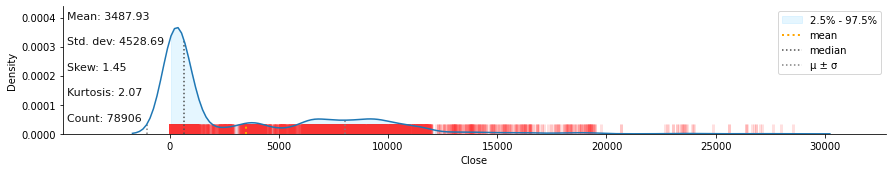

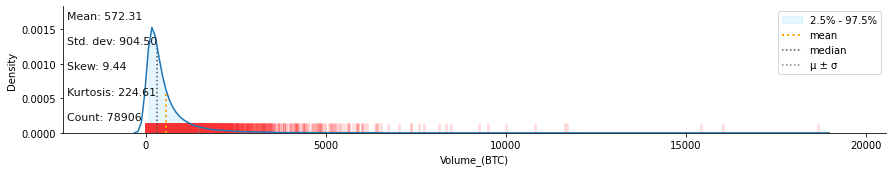

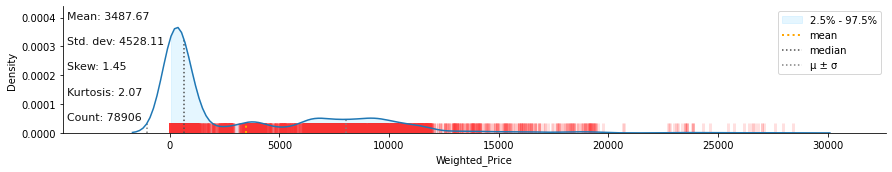

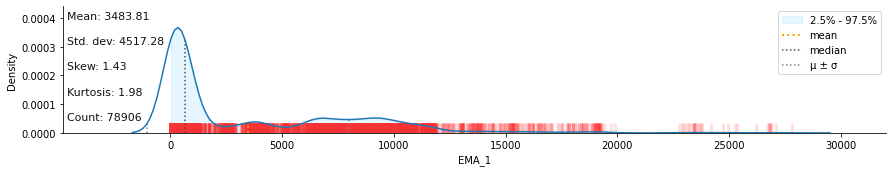

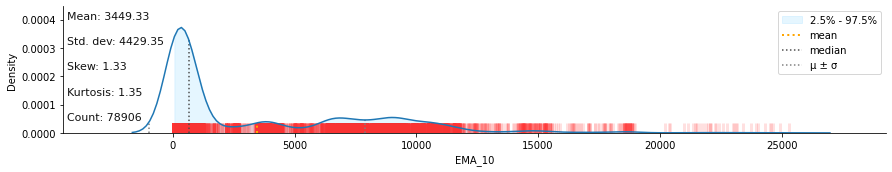

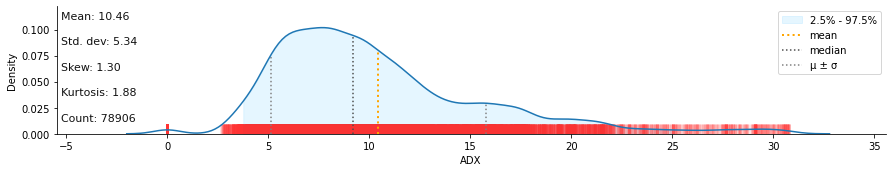

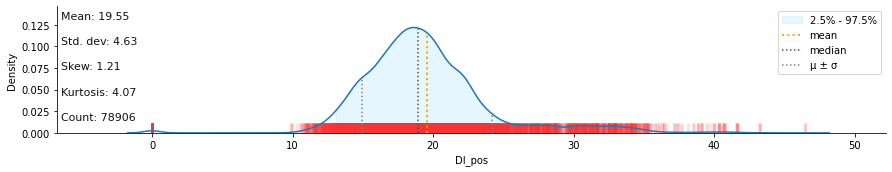

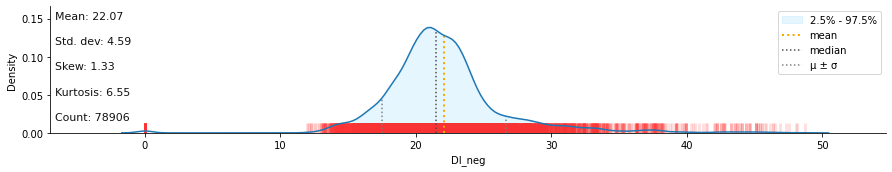

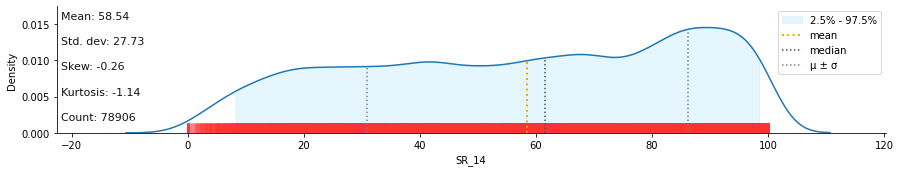

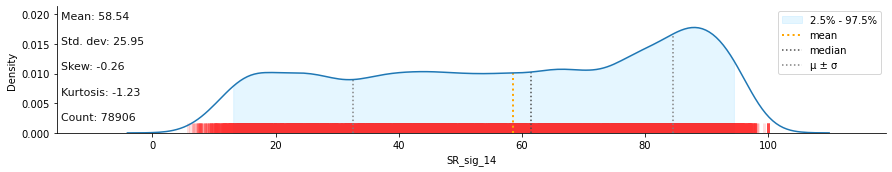

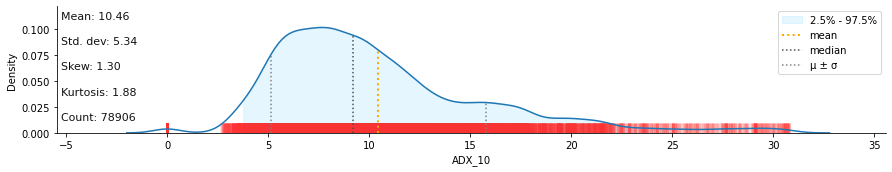

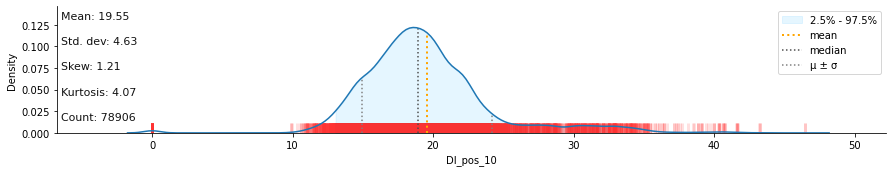

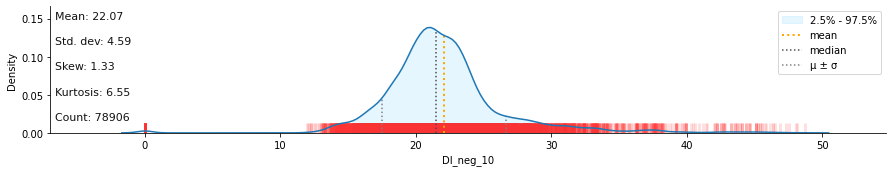

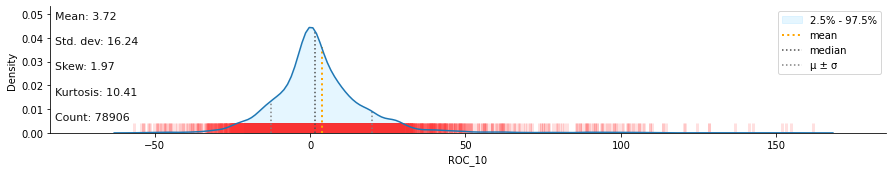

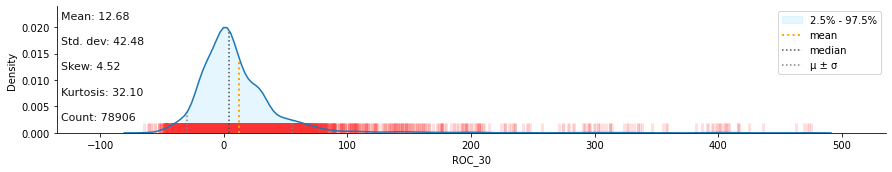

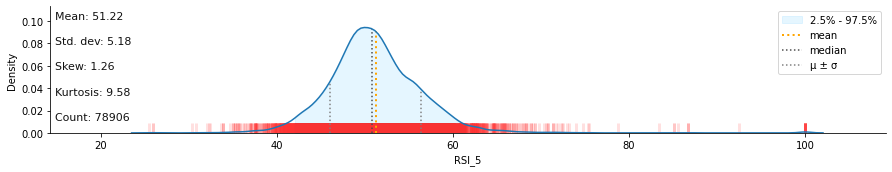

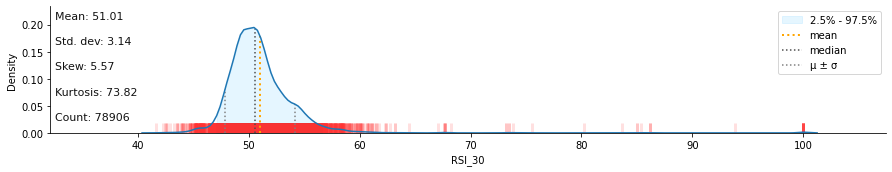

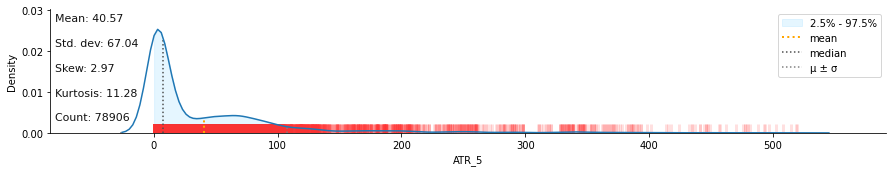

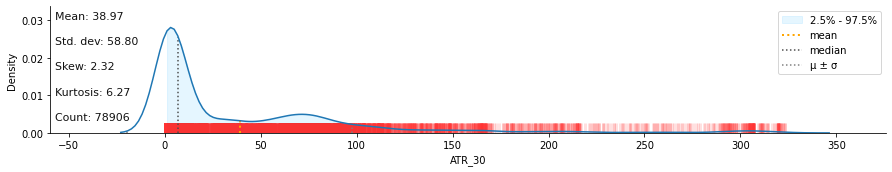

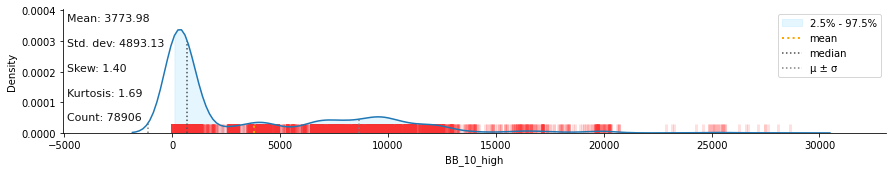

In [ ]:
# Plot data distributions
klib.dist_plot(data_clean)


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

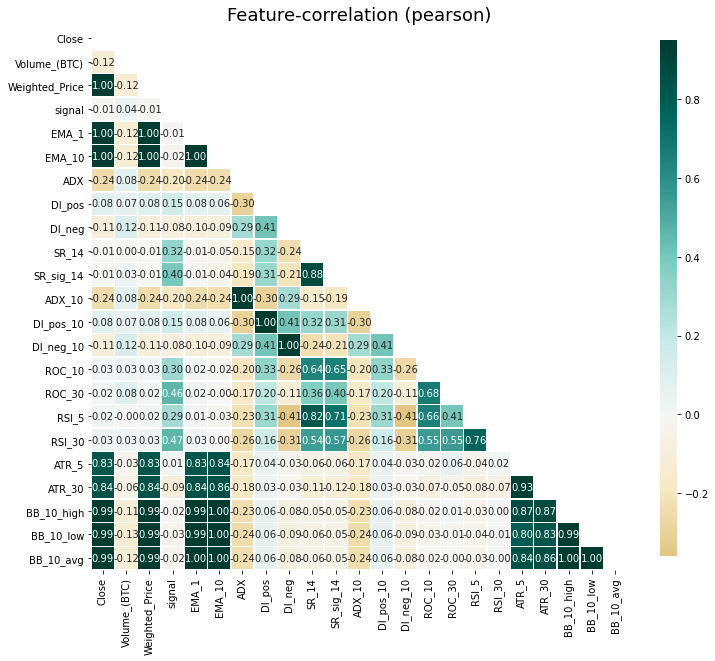

In [ ]:
# Plot correlation matrix
klib.corr_plot(data_clean)

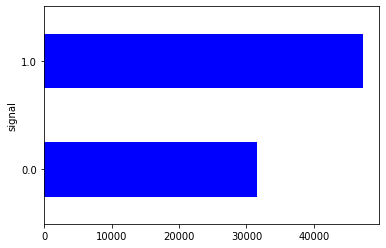

In [ ]:
# Check class balance:
data_clean.groupby(['signal']).size().plot(kind='barh', color='blue')
plt.show()


Class 1 is higher than class 0, which indicates the trend of Bitcoin from 2012 upto end of 2020 is increasing. Let's confirm through the price plot. 

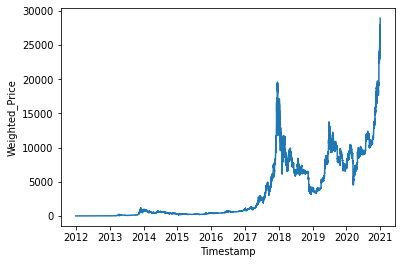

In [ ]:
# Plot Weight_price from 2012 to 2020
sns.lineplot(data=data_clean["Weighted_Price"])
plt.show()

## 3. Models

### 3.1 Train, test set
     Firstly, we will split data to train and test set.

In [19]:
# create X
X = data_clean.drop('signal', axis=1)

# create Y
Y = data_clean['signal']


In [20]:
# Create train/test set for time series data
test_size = 0.2
train_size = int(len(X)* (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(Y)]


### 3.2 Choose baseline model

In [ ]:
# Create a list of model to test
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GB', XGBClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

Split train set to 10 fold to cross-validate accuracy using TimeSeriesSplit and then fit to cross_val_score object.

In [ ]:
# Cross validate models
clfs=[]
cv_results =[]
train_results=[]
test_results=[]

for name, model in models:
    clfs.append(name)

    # Create split object for 10 folds
    tsp = TimeSeriesSplit(n_splits=10)
    # Cross validate on train set
    cv_result =  cross_val_score(model, X_train,y_train, cv=tsp, scoring= 'accuracy')
    # Append result to result list
    cv_results.append(cv_result)

    table = "%s: %f (%f)"%(name, cv_result.mean(), cv_result.std())
    print(table)

LR: 0.793865 (0.114485)
LDA: 0.657424 (0.130067)
KNN: 0.618752 (0.183727)
CART: 0.760509 (0.182097)
NB: 0.660317 (0.173197)
AB: 0.768194 (0.190340)
[15:07:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed

Visualize result to choose the best classifier among mentionned models.

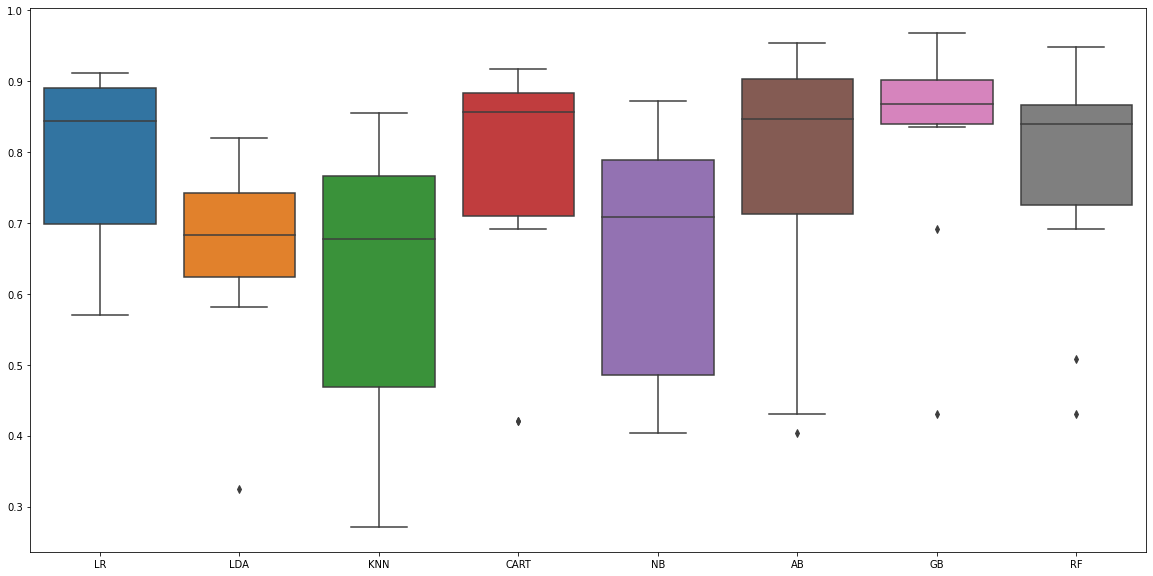

In [ ]:
# Create cv_df
cv_df = pd.DataFrame(data= cv_results, index=clfs).T
# Visualize cross-validation results

plt.figure(figsize=(20,10))
sns.boxplot(data=cv_df)
sns.set_style('darkgrid')

Overall, some models such as Linear Regression, Decision Tree, Ada Boost and XGB can achieve the best accuracy approximately 88%. However, XGB is the most stable model which has the smallest standard deviation.

The fact that we can have a wide range of accuracy due to the fact that TimeSeriesSplit naturally split data into 10 fold based on Timestamp index. This results in some initial folds will have less data to train compare to latter folds.  

 Moreover, from 2012 upto 2017, Bitcoin price evidently lower than the recent period, especially compared to 2020 which marked all-time-high for Bitcoin. 

### 3.3 Finalize models
     We will go ahead with XGB, which show the most stable and highest accuracy score.

In [21]:
# Apply feature transformation for X_train and X_test

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest e found: ", randomized_mse.best_score_)

In [ ]:
# Preconfigure estimator and parameters
estimator = XGBClassifier()
params = {  
            "n_estimators": st.randint(10,150 ),
            "max_depth": st.randint(5, 40),
            "learning_rate": st.uniform(0.05, 1),
            'objective': ['binary:logistic'],
            "colsample_bytree": st.beta(10, 1),
            "subsample": st.beta(10, 1),
            "gamma": st.uniform(0, 10),
            'scale_pos_weight': st.randint(0, 2),
            "min_child_weight": st.expon(0, 50),
        }
# Split data
tsp = TimeSeriesSplit(n_splits=5)

# Random Search Training with 5 folds Cross Validation
classifier = RandomizedSearchCV(estimator, params, cv=tsp,
                         n_jobs=-1, n_iter=100) 
# Fit on train set                              
classifier.fit(X_train_scaled, y_train)  




In [ ]:
# Save Radonmized Search CV save params and score
best_params = classifier.best_params_
best_score = classifier.best_score_


In [ ]:
print(best_params)
print(best_score)

{'colsample_bytree': 0.9133282855778458, 'gamma': 8.680447569225185, 'learning_rate': 0.6462284843146039, 'max_depth': 12, 'min_child_weight': 139.22790776850368, 'n_estimators': 89, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.8605713537674045}
0.8863498098859315


### 3.4 Fit the best model 
     In this section, we will use the best_params learn from RandommizedGridSearch to train and predict on test set.

In [37]:
# Create XBG object
xgb_class = XGBClassifier(colsample_bytree= 0.9133282855778458, 
                          gamma= 8.680447569225185, 
                          learning_rate= 0.6462284843146039, 
                          max_depth= 12, 
                          min_child_weight= 139.22790776850368, 
                          n_estimators= 89, 
                          objective = 'binary:logistic',
                           scale_pos_weight= 1, 
                           subsample= 0.8605713537674045,
                           eval_metric= 'error')


In [38]:
# Fit on train set
xgb_class.fit(X_train_scaled, y_train)

# Predict on test set
prediction = xgb_class.predict(X_test_scaled)

/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall, the model can predict well true high signal (96%) but not true low signal (82%). One explanation for this is because of the overal bullish trend of Bitcoin,and high signal data point proportion is higher than low signal.  
One solution that might help to improve model performance is to oversample low signal data points.  

In [39]:
# Return results:
print(accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

0.9098339880876949
[[5003 1081]
 [ 342 9356]]
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      6084
         1.0       0.90      0.96      0.93      9698

    accuracy                           0.91     15782
   macro avg       0.92      0.89      0.90     15782
weighted avg       0.91      0.91      0.91     15782



### 3.5 Try out SMOTE to improve performance

From the plot below, class 0 seems to overlap with class 1, however, there is a certain amount of data stand out from class 1. Let's try out oversampling technique to create more of class 0.

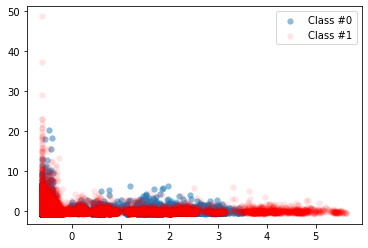

In [44]:
# create a scatter plot of our data and labels

plt.scatter(X_train_scaled[y_train == 0, 0], X_train_scaled[y_train == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_train_scaled[y_train == 1, 0], X_train_scaled[y_train == 1, 1], label="Class #1", alpha=0.1, linewidth=0.15, c='r')
plt.legend()
plt.show()



In [49]:
from imblearn.over_sampling import SMOTE

In [52]:
# Define the resampling method
method = SMOTE(sampling_strategy='auto', random_state = 42)

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X_train_scaled, y_train)

In [53]:
# Create XBG object
xgb_class_2 = XGBClassifier(colsample_bytree= 0.9133282855778458, 
                          gamma= 8.680447569225185, 
                          learning_rate= 0.6462284843146039, 
                          max_depth= 12, 
                          min_child_weight= 139.22790776850368, 
                          n_estimators= 89, 
                          objective = 'binary:logistic',
                           scale_pos_weight= 1, 
                           subsample= 0.8605713537674045,
                           eval_metric= 'error')

In [54]:
# Fit on train set
xgb_class_2.fit(X_resampled, y_resampled)

# Predict on test set
prediction_2 = xgb_class.predict(X_test_scaled)

/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


From the result below, we did not improve accuracy from performing SMOTE. One possible reason is because this data set are not significantly imbalanced.

In [55]:
# Return results:
print(accuracy_score(y_test, prediction_2))
print(confusion_matrix(y_test, prediction_2))
print(classification_report(y_test, prediction_2))

0.9098339880876949
[[5003 1081]
 [ 342 9356]]
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      6084
         1.0       0.90      0.96      0.93      9698

    accuracy                           0.91     15782
   macro avg       0.92      0.89      0.90     15782
weighted avg       0.91      0.91      0.91     15782



### 3.6 Feature Importance
    Let explore important features to understand which features contribute better to the prediction.

The 2 most important features for model predictions are momentum indicators which are mainly used to identify overbought and oversold conditions of an asset.  
In future model, we should probably add more momentum indicators as well as different period range to see if they help improve model's performance.

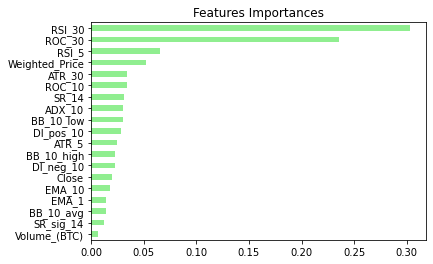

In [40]:

# Create a pd.Series of features importances
importances = pd.Series(data=xgb_class.feature_importances_,
                        index=X_train.columns )

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## 4. Backtesting on Returns
    Let's test the strategy on relevant historical data to make sure that it’s an actual viable strategy.

<AxesSubplot:>

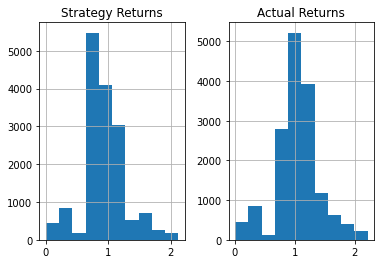

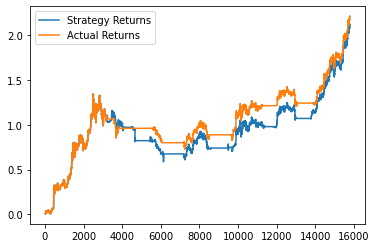

In [59]:
#Compare market and strategy daily return
backtest = pd.DataFrame(index=X_test.index)
#backtestdata = pd.DataFrame()
backtest['signal_pred'] = prediction
backtest['signal_actual'] = y_test
backtest['Market Returns'] = X_test['Close'].pct_change()
backtest['Actual Returns'] = backtest['Market Returns'] * backtest['signal_actual'].shift(24)
backtest['Strategy Returns'] = backtest['Market Returns'] * backtest['signal_pred'].shift(24)
backtest=backtest.reset_index()
backtest.head()
# Plot 2 returns
backtest[['Strategy Returns','Actual Returns']].cumsum().hist()
backtest[['Strategy Returns','Actual Returns']].cumsum().plot()

The cumulative return of the market and strategy certainly slightly deviates which requires more room of improvement.   
Future stragedy for improvement can be incorporate news headline sentiment as a feature to predict trading signal. 

## 5. Conclusion
    

- The model above was built solely using technical indicators and historical data of Bitcoin to predict High and Low signal to aid trading decision.  
- There were two big events that affect Bitcoin price in the recent period that can not capture by models:    
 1st : Cryptocurrency market and financial market as a whole experienced a Mar crash in 2020 because of the pandemic.
 2nd: Bitcoin halving.  
 - Despite the market shock, our model can predict signals with 90% accuracy with just historical data and enginnered features (techinical indicators).  
 - In order to improve model, we can try incorporating NLP technique to add market sentiment as a feature aiding model to understand real-life event effect and its results to asset's price.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7363035f-46b3-4a84-94b1-bbbd1e938e76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>